In [6]:
import pandas as pd
import numpy as np
import warnings
import time

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings('ignore')

In [2]:
# read datasets 
enc = pd.read_csv('../data/regional_datasets/univariate/enc_data_univ.csv')
esc = pd.read_csv('../data/regional_datasets/univariate/esc_data_univ.csv')
mid_atlantic = pd.read_csv('../data/regional_datasets/univariate/mid_atlantic_data_univ.csv')
mountain = pd.read_csv('../data/regional_datasets/univariate/mountain_data_univ.csv')
new_england = pd.read_csv('../data/regional_datasets/univariate/new_england_data_univ.csv')
pacific = pd.read_csv('../data/regional_datasets/univariate/pacific_data_univ.csv')
south_atlantic = pd.read_csv('../data/regional_datasets/univariate/south_atlantic_data_univ.csv')
wnc = pd.read_csv('../data/regional_datasets/univariate/wnc_data_univ.csv')
wsc = pd.read_csv('../data/regional_datasets/univariate/wsc_data_univ.csv')
datasets = [enc, esc, mid_atlantic, mountain, new_england, pacific, south_atlantic, wnc, wsc]
for df in datasets:
    df.set_index(pd.to_datetime(df['date']), inplace=True)
    df.drop(columns=["Unnamed: 0", "date"], axis=1, inplace=True)
    df.sort_index(inplace=True)
    


# ARIMA

In [14]:
def baseline_arima_model(df, params=None, plot=False):
    region = df["region"].iloc[0]
    print(f"Training model for {region}...")

    size = round(df.shape[0]*0.15)
    train = df.iloc[:-size]['new_confirmed']
    test = df.iloc[-size:]['new_confirmed']

    # train_log = np.log(train)
    # train_log.replace([np.inf, -np.inf], 0, inplace=True)

    if params:
        model = ARIMA(train, order=params)
    else:
        model = ARIMA(train, order=(4,1,4))
    model_fit = model.fit()

    pred = model_fit.forecast(steps=size)
    pred = pred
    

    # calculate metrics
    mae = mean_absolute_error(test, pred)
    mse = mean_squared_error(test, pred)
    rmse = mean_squared_error(test, pred, squared=False)
    mase = mean_absolute_scaled_error(test, pred, y_train=train)

    print(f'MAE: {round(mae, 2)}')
    print(f'MSE: {round(mse, 2)}')
    print(f'RMSE: {round(rmse, 2)}')
    print(f'MASE: {round(mase, 2)}')

    # plot predictions
    if plot:
        plt.figure(figsize=(15, 5))
        plt.title(f'ARIMA Predictions for {region}')
        plt.plot(test.index, test, label='True')
        plt.plot(pred.index, pred, label='Predicted')
        plt.legend() 
        plt.show()

In [10]:
start_time = time.time()
for df in datasets:
    baseline_arima_model(df)
    print("")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")

Training model for East North Central...
MAE: 9545.91
MSE: 164254465.49
RMSE: 12816.18
MASE: 1.16

Training model for East South Central...
MAE: 4349.95
MSE: 47126205.34
RMSE: 6864.85
MASE: 1.27

Training model for Mid-Atlantic...
MAE: 7712.74
MSE: 102255338.3
RMSE: 10112.14
MASE: 3.61

Training model for Mountain...
MAE: 5227.77
MSE: 55416576.42
RMSE: 7444.23
MASE: 1.66

Training model for New England...
MAE: 2768.47
MSE: 19121599.52
RMSE: 4372.83
MASE: 1.09

Training model for Pacific...
MAE: 12533.77
MSE: 336998290.84
RMSE: 18357.51
MASE: 1.85

Training model for South Atlantic...
MAE: 14538.88
MSE: 496489043.66
RMSE: 22282.03
MASE: 1.34

Training model for West North Central...
MAE: 3682.43
MSE: 17567306.0
RMSE: 4191.34
MASE: 1.12

Training model for West South Central...
MAE: 6168.91
MSE: 76047217.1
RMSE: 8720.51
MASE: 1.35

--- 7.5 seconds ---


## Parameter Optimization

In [11]:
def parameter_tune(df):
    region = df["region"].iloc[0]
    print(f"Training model for {region}...")

    size = round(df.shape[0]*0.15)
    train = df.iloc[:-size]['new_confirmed']
    test = df.iloc[-size:]['new_confirmed']

    results = []
    for p in range(1, 5):
        for d in range(2):
            for q in range(1, 5):
                model = ARIMA(train, order=(p,d,q))
                model_fit = model.fit()

                pred = model_fit.forecast(steps=size)

                # calculate metrics
                mae = mean_absolute_error(test, pred)
                mse = mean_squared_error(test, pred)
                rmse = mean_squared_error(test, pred, squared=False)
                mase = mean_absolute_scaled_error(test, pred, y_train=train)

                results.append([p, d, q, mae, mse, rmse, mase, model_fit.aic])
                
    results = pd.DataFrame(results, columns=["p", "d", "q", "mae", "mse", "rmse", "mase", "aic"])
    results.sort_values(by="mase", inplace=True)
    print(results.head())

In [13]:
start_time = time.time()
for df in datasets:
    parameter_tune(df)
    print("")

print(f"--- {round(time.time() - start_time, 2)} seconds ---")

Training model for East North Central...
    p  d  q          mae           mse         rmse      mase           aic
23  2  0  3  7889.156943  9.707672e+07  9852.751893  0.961703  17131.992120
42  4  0  2  7900.419198  9.664764e+07  9830.953228  0.963076  17051.397716
34  3  0  4  7904.963624  9.666994e+07  9832.087516  0.963630  17025.549225
24  2  0  4  7970.034690  9.729958e+07  9864.054778  0.971562  17049.070061
41  4  0  1  7972.111878  9.755457e+07  9876.971545  0.971816  17151.671077

Training model for East South Central...
    p  d  q          mae           mse         rmse      mase           aic
25  2  1  0  4100.586175  3.931950e+07  6270.526571  1.201053  15888.369006
17  1  1  2  4102.991181  3.905376e+07  6249.300746  1.201757  15718.642597
15  1  1  0  4111.912767  4.313143e+07  6567.452027  1.204370  16023.282731
27  2  1  2  4120.189032  3.799600e+07  6164.089889  1.206794  15718.410139
18  1  1  3  4124.173113  3.785240e+07  6152.430456  1.207961  15720.673963

Trai

In [15]:
params = {
    "East North Central": (2, 0, 3),
    "East South Central": (2, 1, 0),
    "Mid-Atlantic": (4, 0, 2),
    "Mountain": (4, 1, 3),
    "New England": (4, 1, 4),
    "Pacific": (1, 0, 3),
    "South Atlantic": (1, 0, 3),
    "West North Central": (4, 1, 0),
    "West South Central": (1, 0, 4)
}

Training model for East North Central...
MAE: 7889.16
MSE: 97076719.87
RMSE: 9852.75
MASE: 0.96


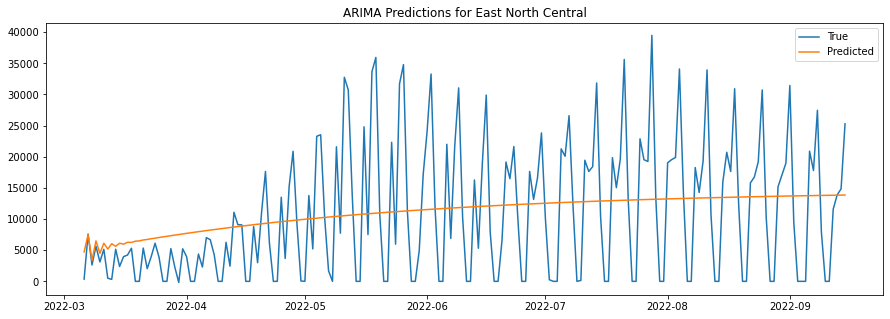


Training model for East South Central...
MAE: 4100.59
MSE: 39319503.48
RMSE: 6270.53
MASE: 1.2


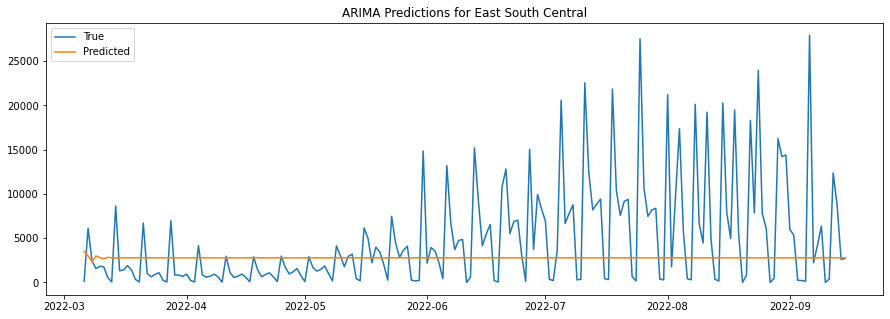


Training model for Mid-Atlantic...
MAE: 4750.26
MSE: 37778133.08
RMSE: 6146.39
MASE: 2.22


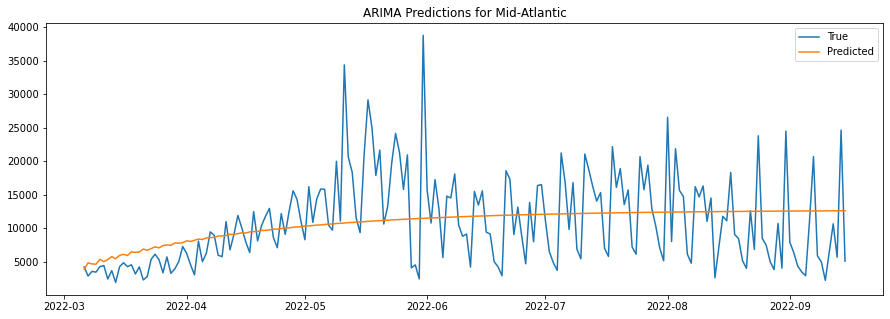


Training model for Mountain...
MAE: 4106.43
MSE: 44243102.57
RMSE: 6651.55
MASE: 1.3


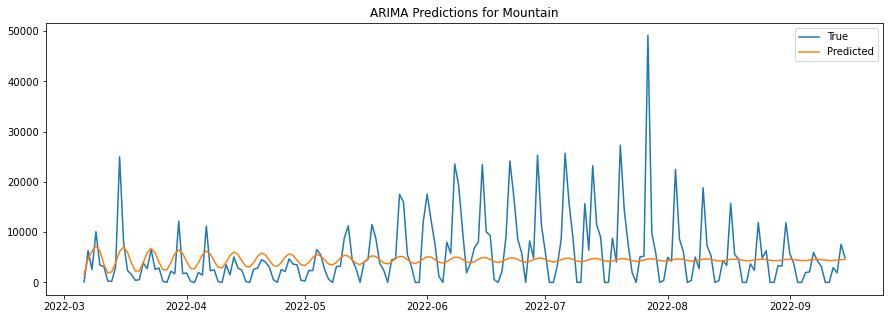


Training model for New England...
MAE: 2768.47
MSE: 19121599.52
RMSE: 4372.83
MASE: 1.09


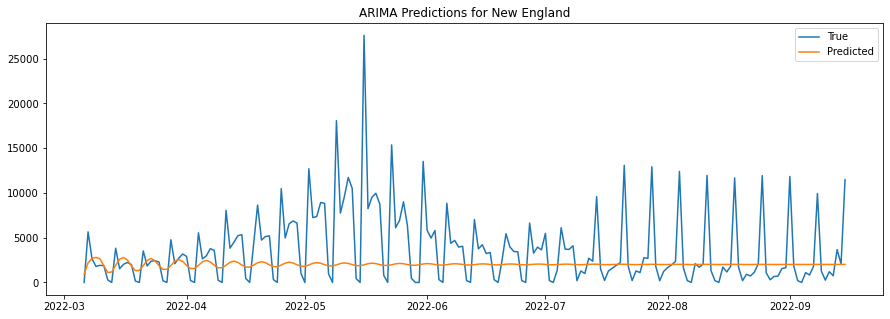


Training model for Pacific...
MAE: 12448.72
MSE: 300127818.09
RMSE: 17324.2
MASE: 1.84


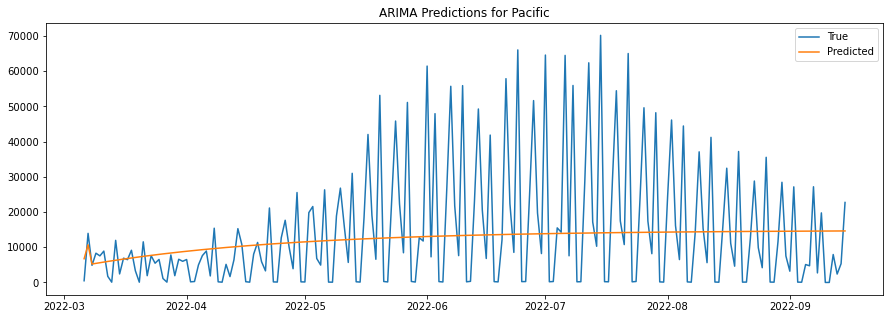


Training model for South Atlantic...
MAE: 12711.58
MSE: 324823176.87
RMSE: 18022.85
MASE: 1.17


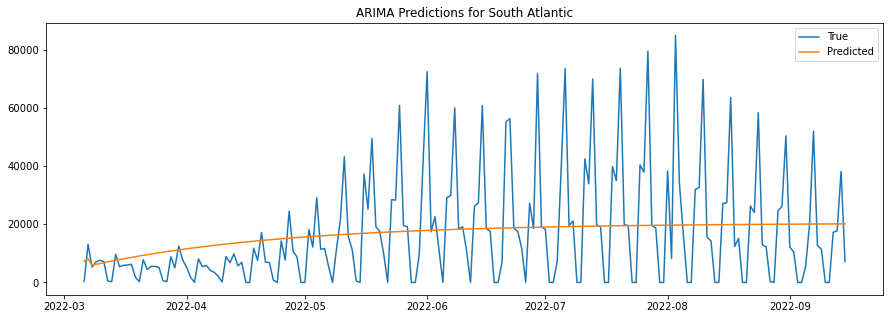


Training model for West North Central...
MAE: 3251.41
MSE: 18400691.79
RMSE: 4289.6
MASE: 0.99


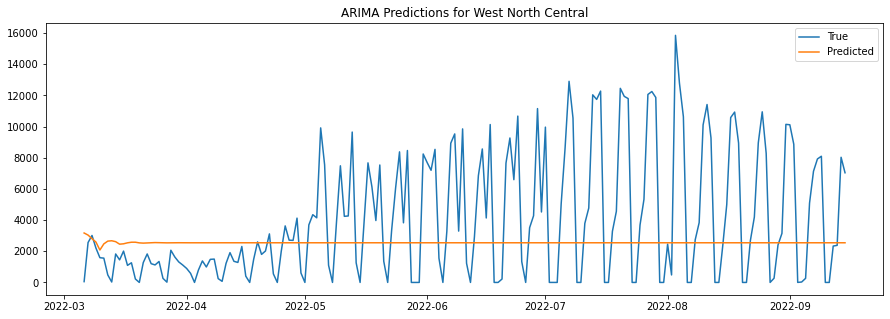


Training model for West South Central...
MAE: 5945.16
MSE: 55995642.79
RMSE: 7483.02
MASE: 1.3


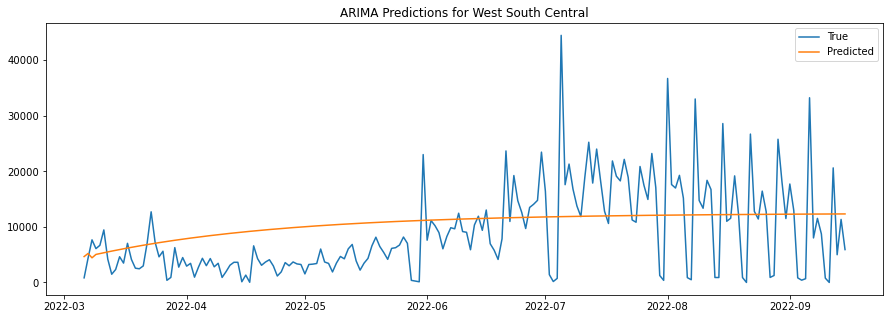


--- 5.06 seconds ---


In [16]:
start_time = time.time()
for df in datasets:
    baseline_arima_model(df, params=params[df["region"].iloc[0]], plot=True)
    print("")

print(f"--- {round(time.time() - start_time, 2)} seconds ---")

## Sarimax

In [49]:
def baseline_sarima_model(df, params=None, seasonal_params=None, plot=False):
    region = df["region"].iloc[0]
    print(f"Training model for {region}...")

    size = round(df.shape[0]*0.15)
    train = df.iloc[:-size]['new_confirmed']
    test = df.iloc[-size:]['new_confirmed']

    if params and seasonal_params:
         model = SARIMAX(train, order=params, seasonal_order=seasonal_params)
    elif params:
        model = SARIMAX(train, order=params, seasonal_order=(1, 1, 1,7))
    else:
        model = SARIMAX(train, order=(2, 0, 3), seasonal_order=(1, 1, 1,7))
    model_fit = model.fit(disp=False)

    pred = model_fit.forecast(steps=size)    

    # calculate metrics
    mae = mean_absolute_error(test, pred)
    mse = mean_squared_error(test, pred)
    rmse = mean_squared_error(test, pred, squared=False)
    mase = mean_absolute_scaled_error(test, pred, y_train=train)
    print(f'MAE: {round(mae, 2)}')
    print(f'MSE: {round(mse, 2)}')
    print(f'RMSE: {round(rmse, 2)}')
    print(f'MASE: {round(mase, 2)}')

    # plot predictions
    if plot:
        plt.figure(figsize=(15, 5))
        plt.title(f'SARIMA Predictions for {region}')
        plt.plot(test.index, test, label='True')
        plt.plot(pred.index, pred, label='Predicted')
        plt.legend() 
        plt.show()



Training model for East North Central...
MAE: 7934.76
MSE: 106268790.03
RMSE: 10308.68
MASE: 1.0


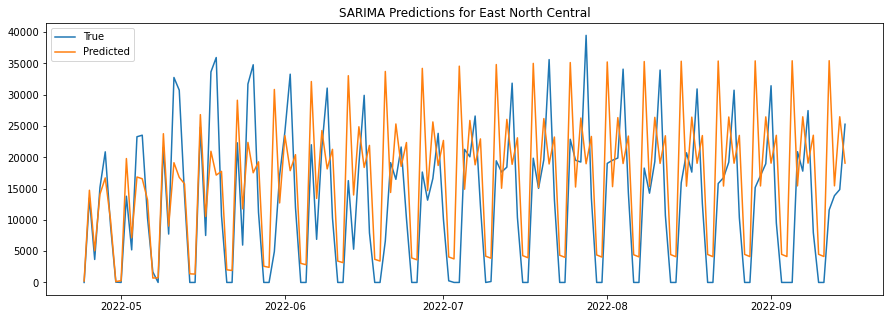


Training model for East South Central...
MAE: 9745.4
MSE: 139333738.07
RMSE: 11803.97
MASE: 2.94


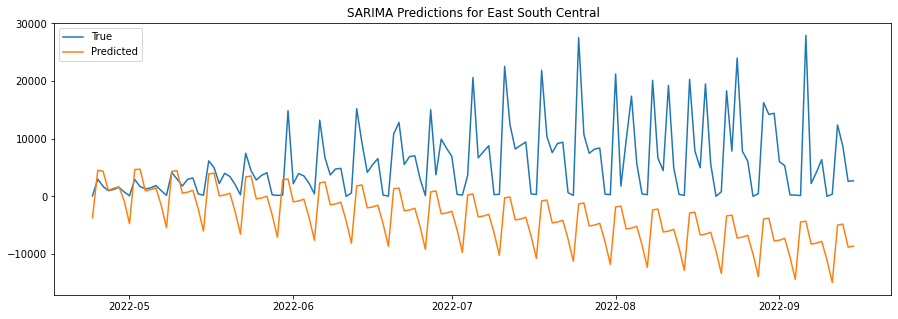


Training model for Mid-Atlantic...
MAE: 6383.61
MSE: 61062057.35
RMSE: 7814.22
MASE: 3.01


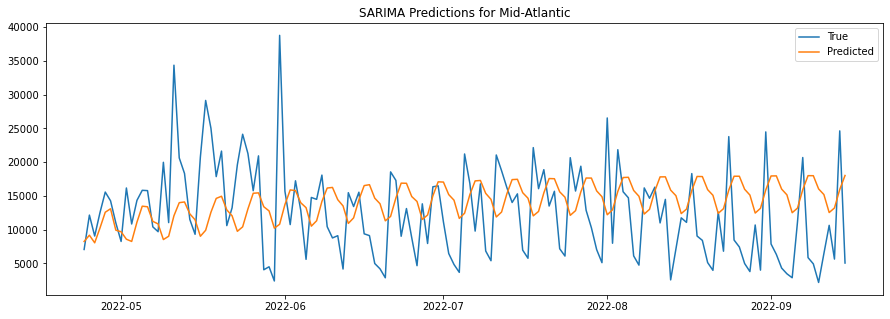


Training model for Mountain...
MAE: 9929.02
MSE: 144266179.69
RMSE: 12011.09
MASE: 3.14


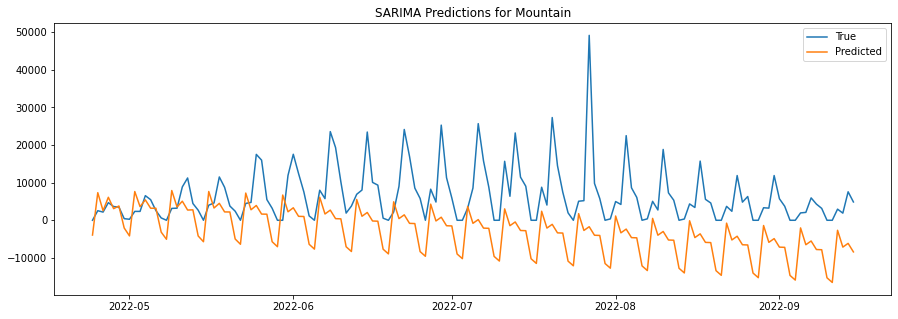


Training model for New England...
MAE: 3353.37
MSE: 18203284.39
RMSE: 4266.53
MASE: 1.34


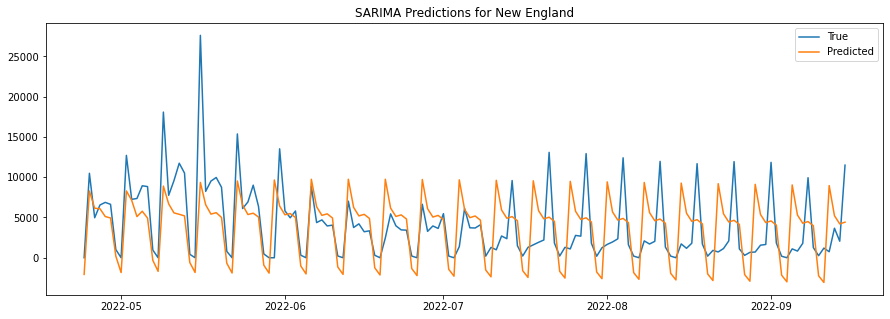


Training model for Pacific...
MAE: 12547.55
MSE: 279777591.77
RMSE: 16726.55
MASE: 1.87


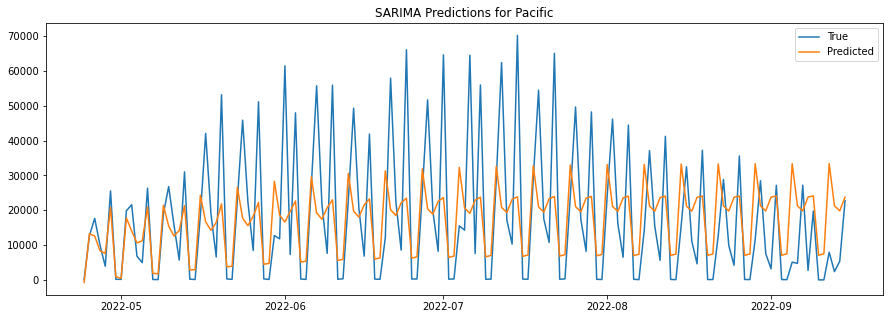


Training model for South Atlantic...
MAE: 12769.0
MSE: 355487308.87
RMSE: 18854.37
MASE: 1.23


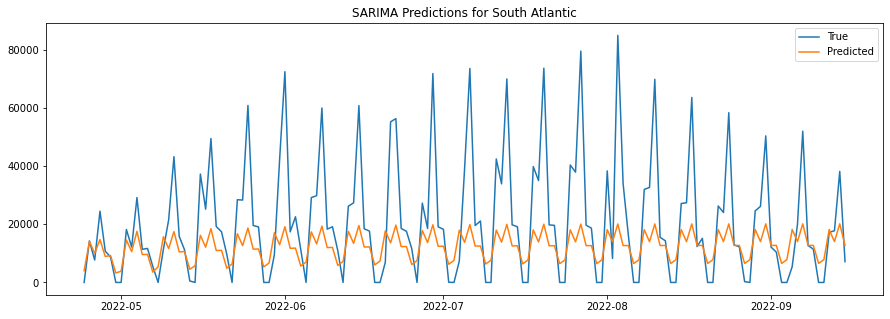


Training model for West North Central...
MAE: 6465.94
MSE: 60144339.28
RMSE: 7755.28
MASE: 2.07


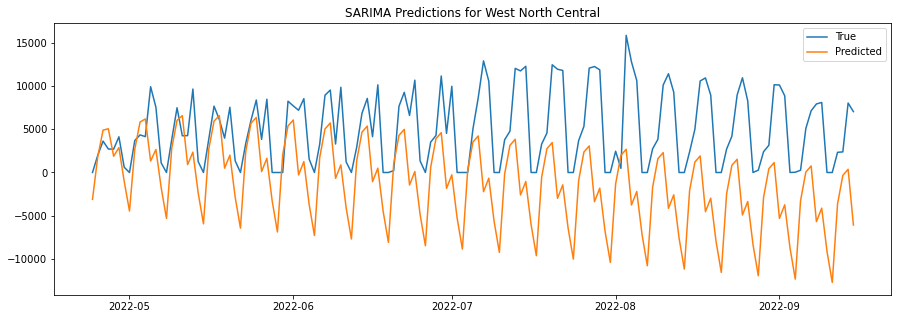


Training model for West South Central...
MAE: 5189.31
MSE: 45579489.98
RMSE: 6751.26
MASE: 1.18


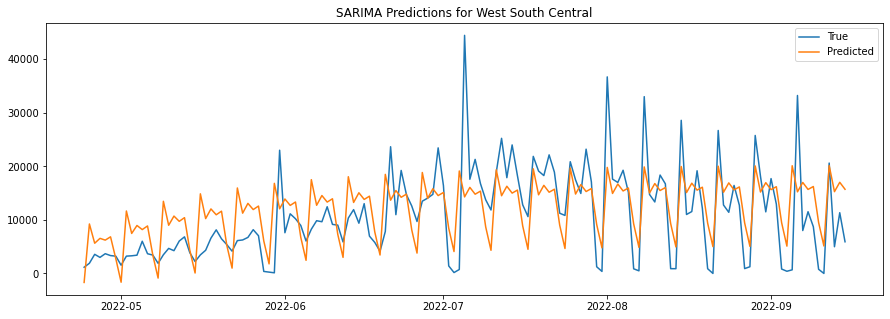


--- 57.33 seconds ---


In [50]:
start_time = time.time()
for df in datasets:
    baseline_sarima_model(df, params=params[df["region"].iloc[0]], plot=True)
    print("")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")

In [51]:
def sarima_parameter_tune(df, params):
    region = df["region"].iloc[0]
    print(f"Training model for {region}...")

    size = round(df.shape[0]*0.15)
    train = df.iloc[:-size]['new_confirmed']
    test = df.iloc[-size:]['new_confirmed']

    results = []
    # for p in range(1, 3):
    #     # for d in range(2):
    #     for q in range(1, 3):
    for P in range(1, 4):
        for D in range(2):
            for Q in range(1, 4):
                model = SARIMAX(train, order=params, seasonal_order=(P, 1, Q, 7))
                model_fit = model.fit(disp=False)

                pred = model_fit.forecast(steps=size)

                # calculate metrics
                mae = mean_absolute_error(test, pred)
                rmse = mean_squared_error(test, pred, squared=False)
                mase = mean_absolute_scaled_error(test, pred, y_train=train)

                results.append([P, D, Q, mae, rmse, mase, model_fit.aic])
                
    results = pd.DataFrame(results, columns=["P", "D", "Q", "mae", "rmse", "mase", "aic"])
    results.sort_values(by="mase", inplace=True)
    print(results.head())

In [52]:
start_time = time.time()
for df in datasets:
    sarima_parameter_tune(df, params[df["region"].iloc[0]])
    print("")
print(f"--- {round(time.time() - start_time, 2)} seconds ---")

Training model for East North Central...
    P  D  Q          mae         rmse      mase           aic
13  3  0  2  7074.895647  9069.035549  0.892340  17268.963566
16  3  1  2  7074.895647  9069.035549  0.892340  17268.963566
1   1  0  2  7107.497416  9103.578303  0.896452  17269.789893
4   1  1  2  7107.497416  9103.578303  0.896452  17269.789893
8   2  0  3  7125.585978  9135.611021  0.898734  17271.981839

Training model for East South Central...
    P  D  Q          mae          rmse      mase           aic
17  3  1  3  8011.742043  10016.818255  2.420329  16549.206465
14  3  0  3  8011.742043  10016.818255  2.420329  16549.206465
11  2  1  3  8162.943018  10171.488523  2.466006  16547.274150
8   2  0  3  8162.943018  10171.488523  2.466006  16547.274150
5   1  1  3  8169.974193  10175.268094  2.468130  16546.106606

Training model for Mid-Atlantic...
    P  D  Q          mae         rmse      mase           aic
15  3  1  1  5712.171432  7085.384784  2.690713  16129.104938
12  3  